In [2]:
## Import Packages
from __future__ import print_function

import numpy as np
import pandas as pd
from itertools import product

#Astro Software
import astropy.units as units
from astropy.coordinates import SkyCoord
from astropy.io import fits

#Plotting Packages
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns

from PIL import Image

from yt.config import ytcfg
import yt
import yt.units as u

#Scattering NN
import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D
device = "cpu"

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA, FastICA

import skimage
from skimage import filters

from scipy.optimize import curve_fit
from scipy import linalg
from scipy import stats
from scipy.signal import general_gaussian

#I/O
import h5py
import pickle
import glob
import copy
import time

#Plotting Style
%matplotlib inline
plt.style.use('dark_background')
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'

#Threading
torch.set_num_threads=2
from multiprocessing import Pool

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    out = os.path.splitext(tail)[0]
    return out

def hd5_open(file_name,name):
    f=h5py.File(file_name,'r', swmr=True)
    data = f[name][:]
    f.close()
    return data

from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1,N=5000)

/opt/miniconda3/envs/IWST/lib/python3.8/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [3]:
def LDA_AKS_testman(X_train,y_train,X_test,y_test,n_components,label_list):
    lda = LDA(n_components=n_components)
    X_train = lda.fit_transform(X_train, y_train)
    y_pred = lda.predict(X_test)
    X_test = lda.transform(X_test)
    cm = confusion_matrix(y_test, y_pred)
    prec = precision_score(y_test, y_pred,average='micro')
    print('Accuracy' + str(prec))
    cmap_normal = (cm.T/cm.sum(axis=1)).T
    
    ## Good plots
    vmin=y_train.min()
    vmax=y_train.max()
    marker_size = 10

    from matplotlib import cm as cmplt
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    rgba_colors = [cmplt.hsv(norm(indx)) for indx, i in enumerate(label_list)]
    color_order = ["black", "white"]
    color_map = "gray"
    colormap='hsv'
    
    fig = plt.figure(figsize=(12,12),dpi=150)

    ax = fig.add_subplot(2,2,1)    
    ax.imshow(cmap_normal,
          interpolation='nearest',
          cmap=color_map,
          aspect='equal',
          vmin=0,vmax=1)

    ax.set_xticks(np.arange(cm.shape[0]))
    ax.set_yticks(np.arange(cm.shape[1]))
    
    for ytick, color in zip(ax.get_yticklabels(), rgba_colors):
        ytick.set_color(color)

    ax.set_xticklabels(label_list)
    ax.set_yticklabels(label_list)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",va='center',
             rotation_mode="anchor")
    plt.title('Test-Train Fidelity ({:.2f}%)'.format(100*prec))

    # Loop over data dimensions and create text annotations.
    textcolors=color_order
    threshold = 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] != 0:
                text = ax.text(j, i, cm[i, j],
                               ha="center", va="center", 
                               color=textcolors[int(cmap_normal[i, j] < threshold)])
    if n_components == 1:
        ax = fig.add_subplot(2,2,2)
        #ax.scatter(X_train, y_train, s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
        #ax.scatter(X_test, y_test, s=2, marker='^', zorder=10,c=y_test, cmap = 'bwr',alpha=0.5)
        sns.distplot(X_test[y_test==0],ax=ax)
        sns.distplot(X_test[y_test==1],ax=ax)
        plt.xlabel('$LDA_{}$'.format(0))
        plt.ylabel('Probability Density')
        plt.title('LDA Projection')
        
    if n_components == 2:
        ax = fig.add_subplot(2,2,2)
        #ax.scatter(X_train[:,0], X_train[:,1], s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
        ax.scatter(X_test[:,0], X_test[:,1], s=2, marker='^', zorder=10,c=y_test, cmap = colormap, vmin=vmin, vmax=vmax,alpha=0.5)
        plt.xlabel('$LDA_{}$'.format(i-2))
        plt.ylabel('$LDA_{}$'.format(i-1))
        plt.title('LDA Projection')
    elif n_components > 2:
        for i in range(2,5):
            ax = fig.add_subplot(2,2,i)
            #ax.scatter(X_train[:,i-2], X_train[:,i-1], s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
            ax.scatter(X_test[:,i-2], X_test[:,i-1], s=2, marker='^', zorder=10,c=y_test, cmap = colormap, vmin=vmin, vmax=vmax,alpha=0.5)
            plt.xlabel('$LDA_{}$'.format(i-2))
            plt.ylabel('$LDA_{}$'.format(i-1))
            plt.title('LDA Projection')

    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()
    
    return (lda,cm,X_train,X_test,y_train,y_test,y_pred)

In [5]:
cifar10_train = hd5_open('../scratch_AKS/data/cifar10_train.h5','main/data')
cifar10_test = hd5_open('../scratch_AKS/data/cifar10_test.h5','main/data')

In [4]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.datasets as ds

In [5]:
train_ds = ds.CIFAR10(root='./data_cache',train=True,download=True, transform=None)
test_ds = ds.CIFAR10(root='./data_cache',train=False,download=True, transform=None)

0it [00:00, ?it/s]

Files already downloaded and verified


In [18]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Accuracy0.5353


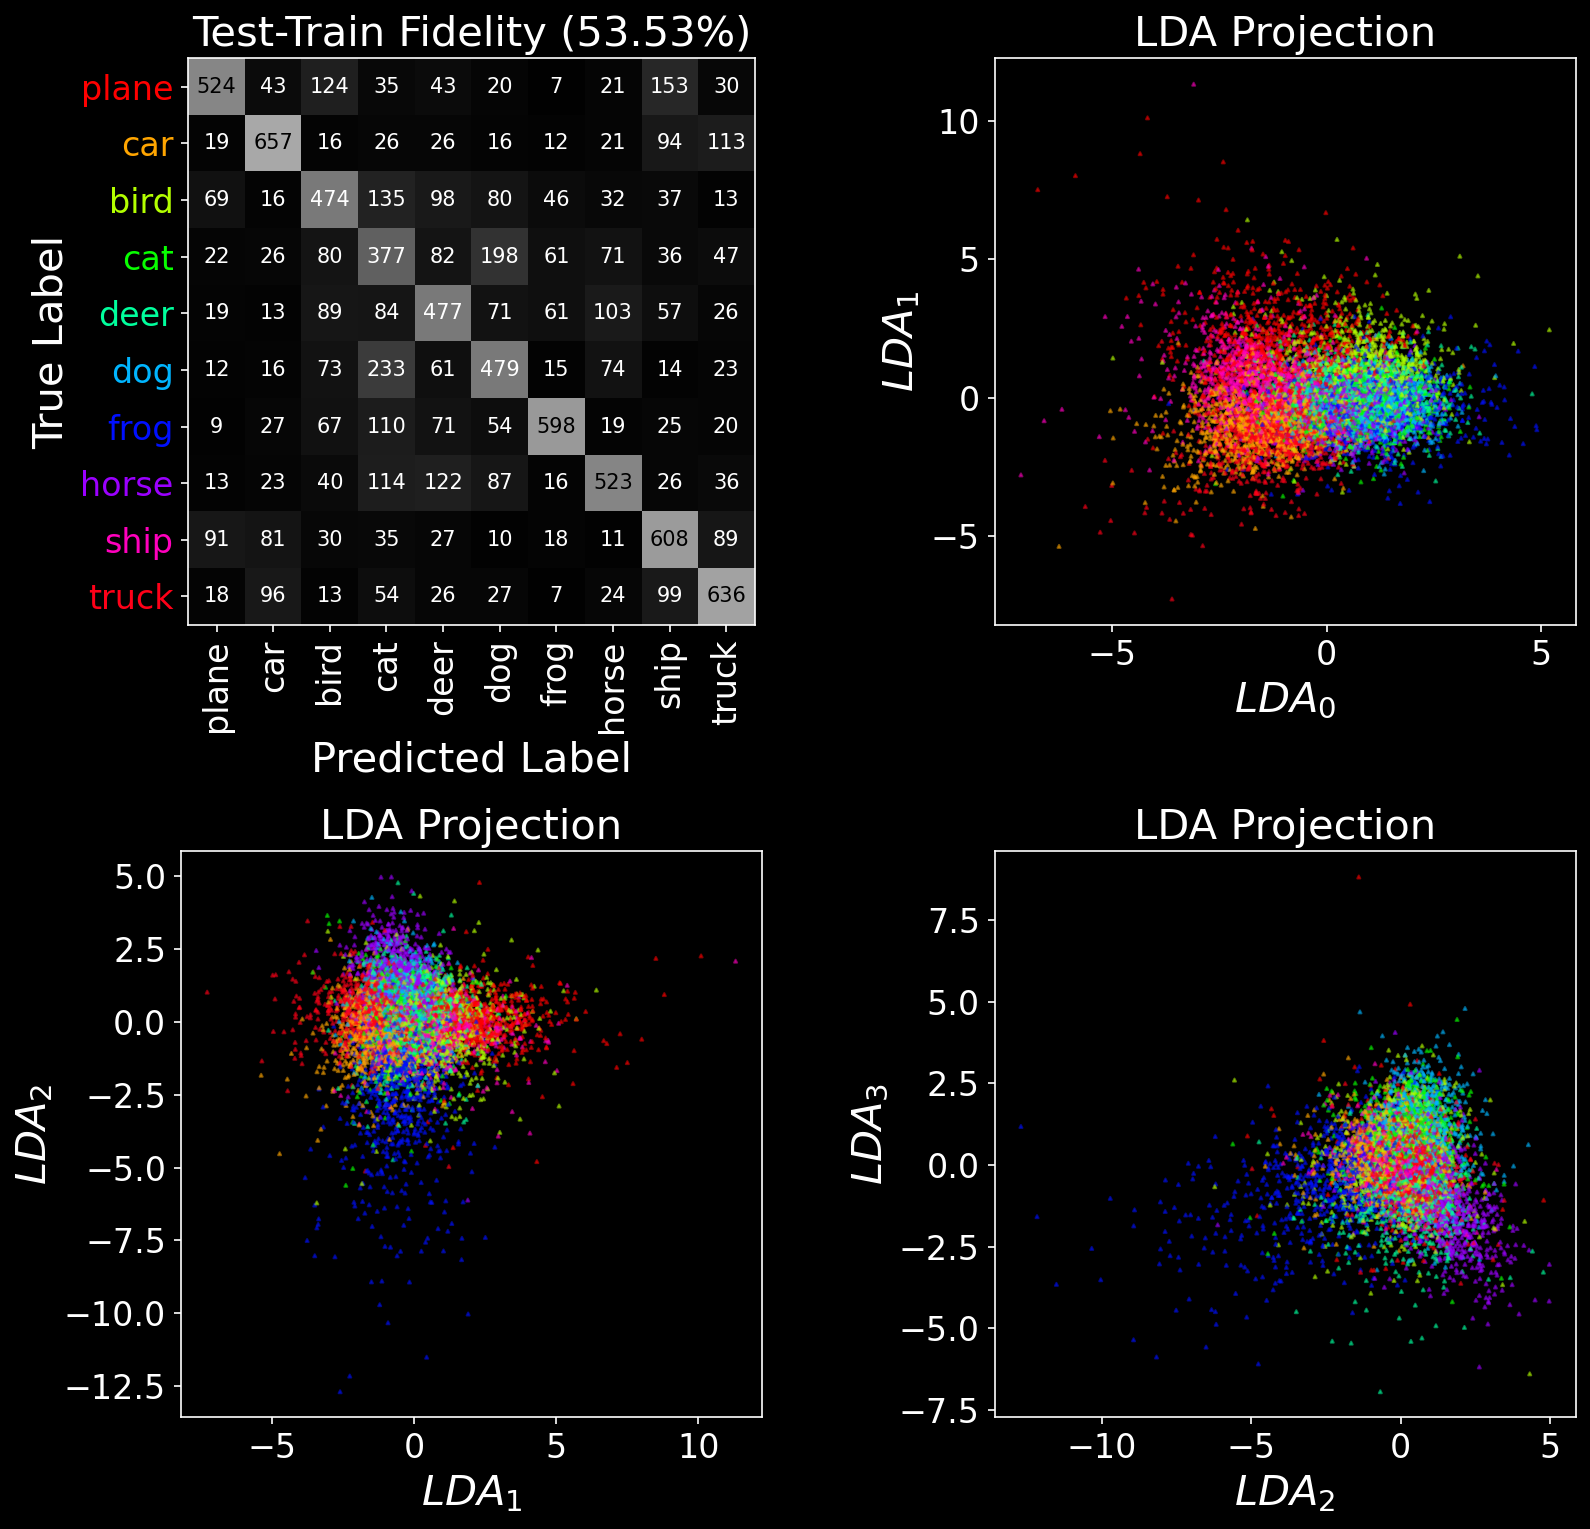

In [26]:
N = 10
labels = [0,1,2,3,4,5,6,7,8,9]
out = LDA_AKS_testman(cifar10_train,
                      np.array(train_ds.targets),
                      cifar10_test,
                      np.array(test_ds.targets),N-1,classes)

In [24]:
def DHC_iso_vec(wst,J,L):
    (nk, Nd) = np.shape(wst)
    S0 = wst[:,0:2]
    S1 = wst[:,2:J*L+2]
    S2 = np.reshape(wst[:,J*L+3:],(nk,(J*L+1),(J*L+1)))
    
    S1iso = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            S1iso[:,j1] += S1[:,l1*J+j1]
    
    S2iso = np.zeros((nk,J,J,L))
    for j1 in range(J):
        for j2 in range(J):
            for l1 in range(L):
                for l2 in range(L):
                    deltaL = np.mod(l1-l2,L)
                    S2iso[:,j1,j2,deltaL] += S2[:,l1*J+j1,l2*J+j2]
                    
    Sphi1 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi1[:,j1] += S2[:,l1*J+j1,L*J]
            
    Sphi2 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi2[:,j1] += S2[:,L*J,l1*J+j1]
            
    return np.hstack((S0,S1iso,wst[:,J*L+2].reshape(nk,1),S2iso.reshape(nk,J*J*L),Sphi1,Sphi2,S2[:,L*J,L*J].reshape(nk,1)))

Accuracy0.4239


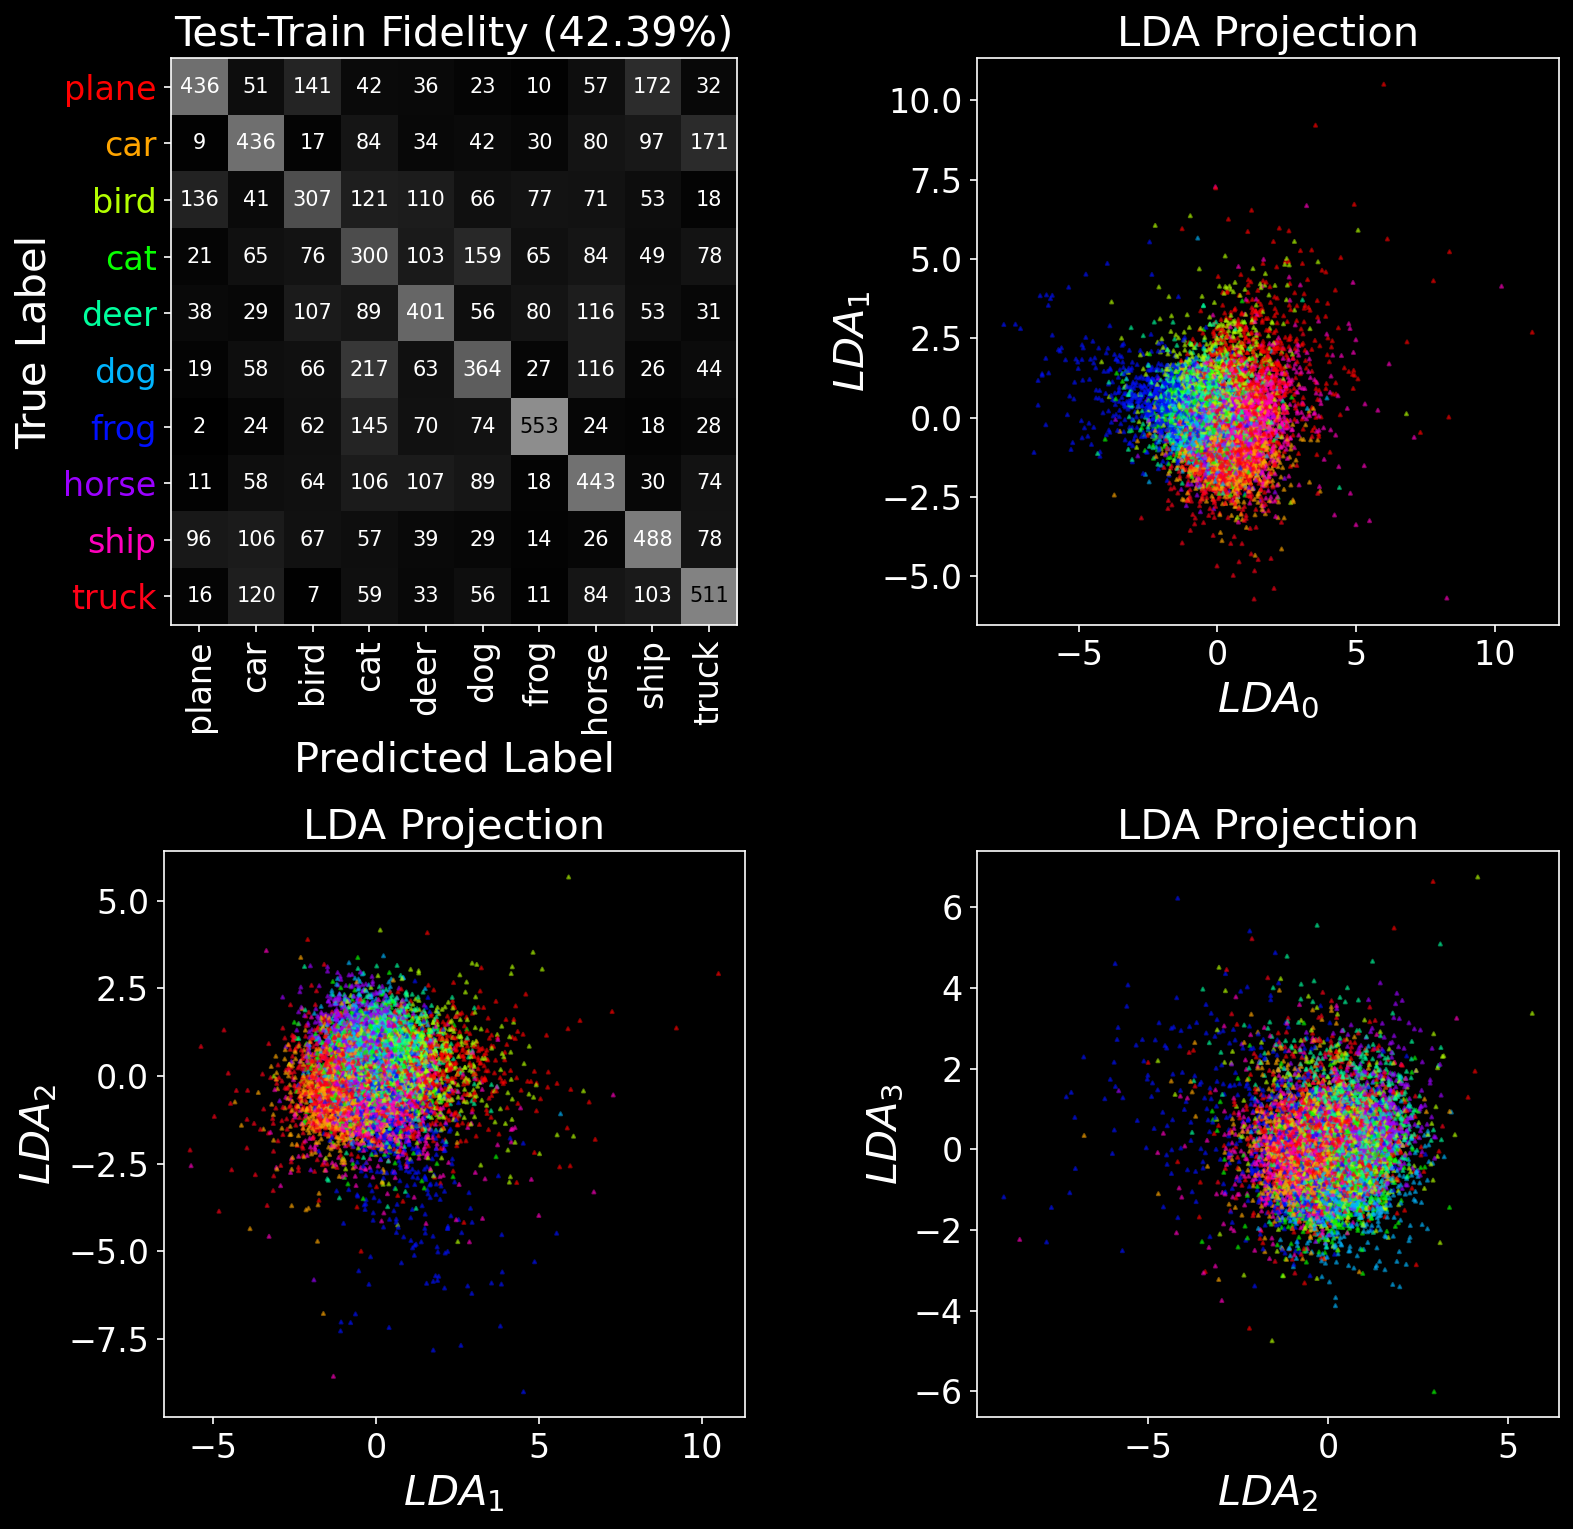

In [25]:
N = 10
labels = [0,1,2,3,4,5,6,7,8,9]
out = LDA_AKS_testman(DHC_iso_vec(cifar10_train,5,8),
                      np.array(train_ds.targets),
                      DHC_iso_vec(cifar10_test,5,8),
                      np.array(test_ds.targets),N-1,classes)

In [1]:
cifar100_train = hd5_open('../scratch_AKS/cifar100_train.h5','main/data')
cifar100_test = hd5_open('../scratch_AKS/cifar100_test.h5','main/data')

NameError: name 'hd5_open' is not defined

In [28]:
train_ds = ds.CIFAR100(root='./data_cache',train=True,download=True, transform=None)
test_ds = ds.CIFAR100(root='./data_cache',train=False,download=True, transform=None)

0it [00:00, ?it/s]

Files already downloaded and verified


In [38]:
def LDA_AKS_testman(X_train,y_train,X_test,y_test,n_components,label_list):
    lda = LDA(n_components=n_components)
    X_train = lda.fit_transform(X_train, y_train)
    y_pred = lda.predict(X_test)
    X_test = lda.transform(X_test)
    cm = confusion_matrix(y_test, y_pred)
    prec = precision_score(y_test, y_pred,average='micro')
    print('Accuracy' + str(prec))
    cmap_normal = (cm.T/cm.sum(axis=1)).T
    
    ## Good plots
    vmin=y_train.min()
    vmax=y_train.max()
    marker_size = 10

    from matplotlib import cm as cmplt
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    rgba_colors = [cmplt.hsv(norm(indx)) for indx, i in enumerate(label_list)]
    color_order = ["black", "white"]
    color_map = "gray"
    colormap='hsv'
    
    fig = plt.figure(figsize=(12,12),dpi=150)

    ax = fig.add_subplot(2,2,1)    
    ax.imshow(cmap_normal,
          interpolation='nearest',
          cmap=color_map,
          aspect='equal',
          vmin=0,vmax=1)

    #ax.set_xticks(np.arange(cm.shape[0]))
    #ax.set_yticks(np.arange(cm.shape[1]))
    
    #for ytick, color in zip(ax.get_yticklabels(), rgba_colors):
    #    ytick.set_color(color)

    #ax.set_xticklabels(label_list)
    #ax.set_yticklabels(label_list)

    #plt.xlabel('Predicted Label')
    #plt.ylabel('True Label')

    #plt.setp(ax.get_xticklabels(), rotation=90, ha="right",va='center',
    #         rotation_mode="anchor")
    plt.title('Test-Train Fidelity ({:.2f}%)'.format(100*prec))

    # Loop over data dimensions and create text annotations.
    #textcolors=color_order
    #threshold = 0.5
    #for i in range(cm.shape[0]):
    #    for j in range(cm.shape[1]):
    #        if cm[i, j] != 0:
    #            text = ax.text(j, i, cm[i, j],
    #                           ha="center", va="center", 
     #                          color=textcolors[int(cmap_normal[i, j] < threshold)])
    if n_components == 1:
        ax = fig.add_subplot(2,2,2)
        #ax.scatter(X_train, y_train, s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
        #ax.scatter(X_test, y_test, s=2, marker='^', zorder=10,c=y_test, cmap = 'bwr',alpha=0.5)
        sns.distplot(X_test[y_test==0],ax=ax)
        sns.distplot(X_test[y_test==1],ax=ax)
        plt.xlabel('$LDA_{}$'.format(0))
        plt.ylabel('Probability Density')
        plt.title('LDA Projection')
        
    if n_components == 2:
        ax = fig.add_subplot(2,2,2)
        #ax.scatter(X_train[:,0], X_train[:,1], s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
        ax.scatter(X_test[:,0], X_test[:,1], s=2, marker='^', zorder=10,c=y_test, cmap = colormap, vmin=vmin, vmax=vmax,alpha=0.5)
        plt.xlabel('$LDA_{}$'.format(i-2))
        plt.ylabel('$LDA_{}$'.format(i-1))
        plt.title('LDA Projection')
    elif n_components > 2:
        for i in range(2,5):
            ax = fig.add_subplot(2,2,i)
            #ax.scatter(X_train[:,i-2], X_train[:,i-1], s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
            ax.scatter(X_test[:,i-2], X_test[:,i-1], s=2, marker='^', zorder=10,c=y_test, cmap = colormap, vmin=vmin, vmax=vmax,alpha=0.5)
            plt.xlabel('$LDA_{}$'.format(i-2))
            plt.ylabel('$LDA_{}$'.format(i-1))
            plt.title('LDA Projection')

    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()
    
    return (lda,cm,X_train,X_test,y_train,y_test,y_pred)

Accuracy0.168


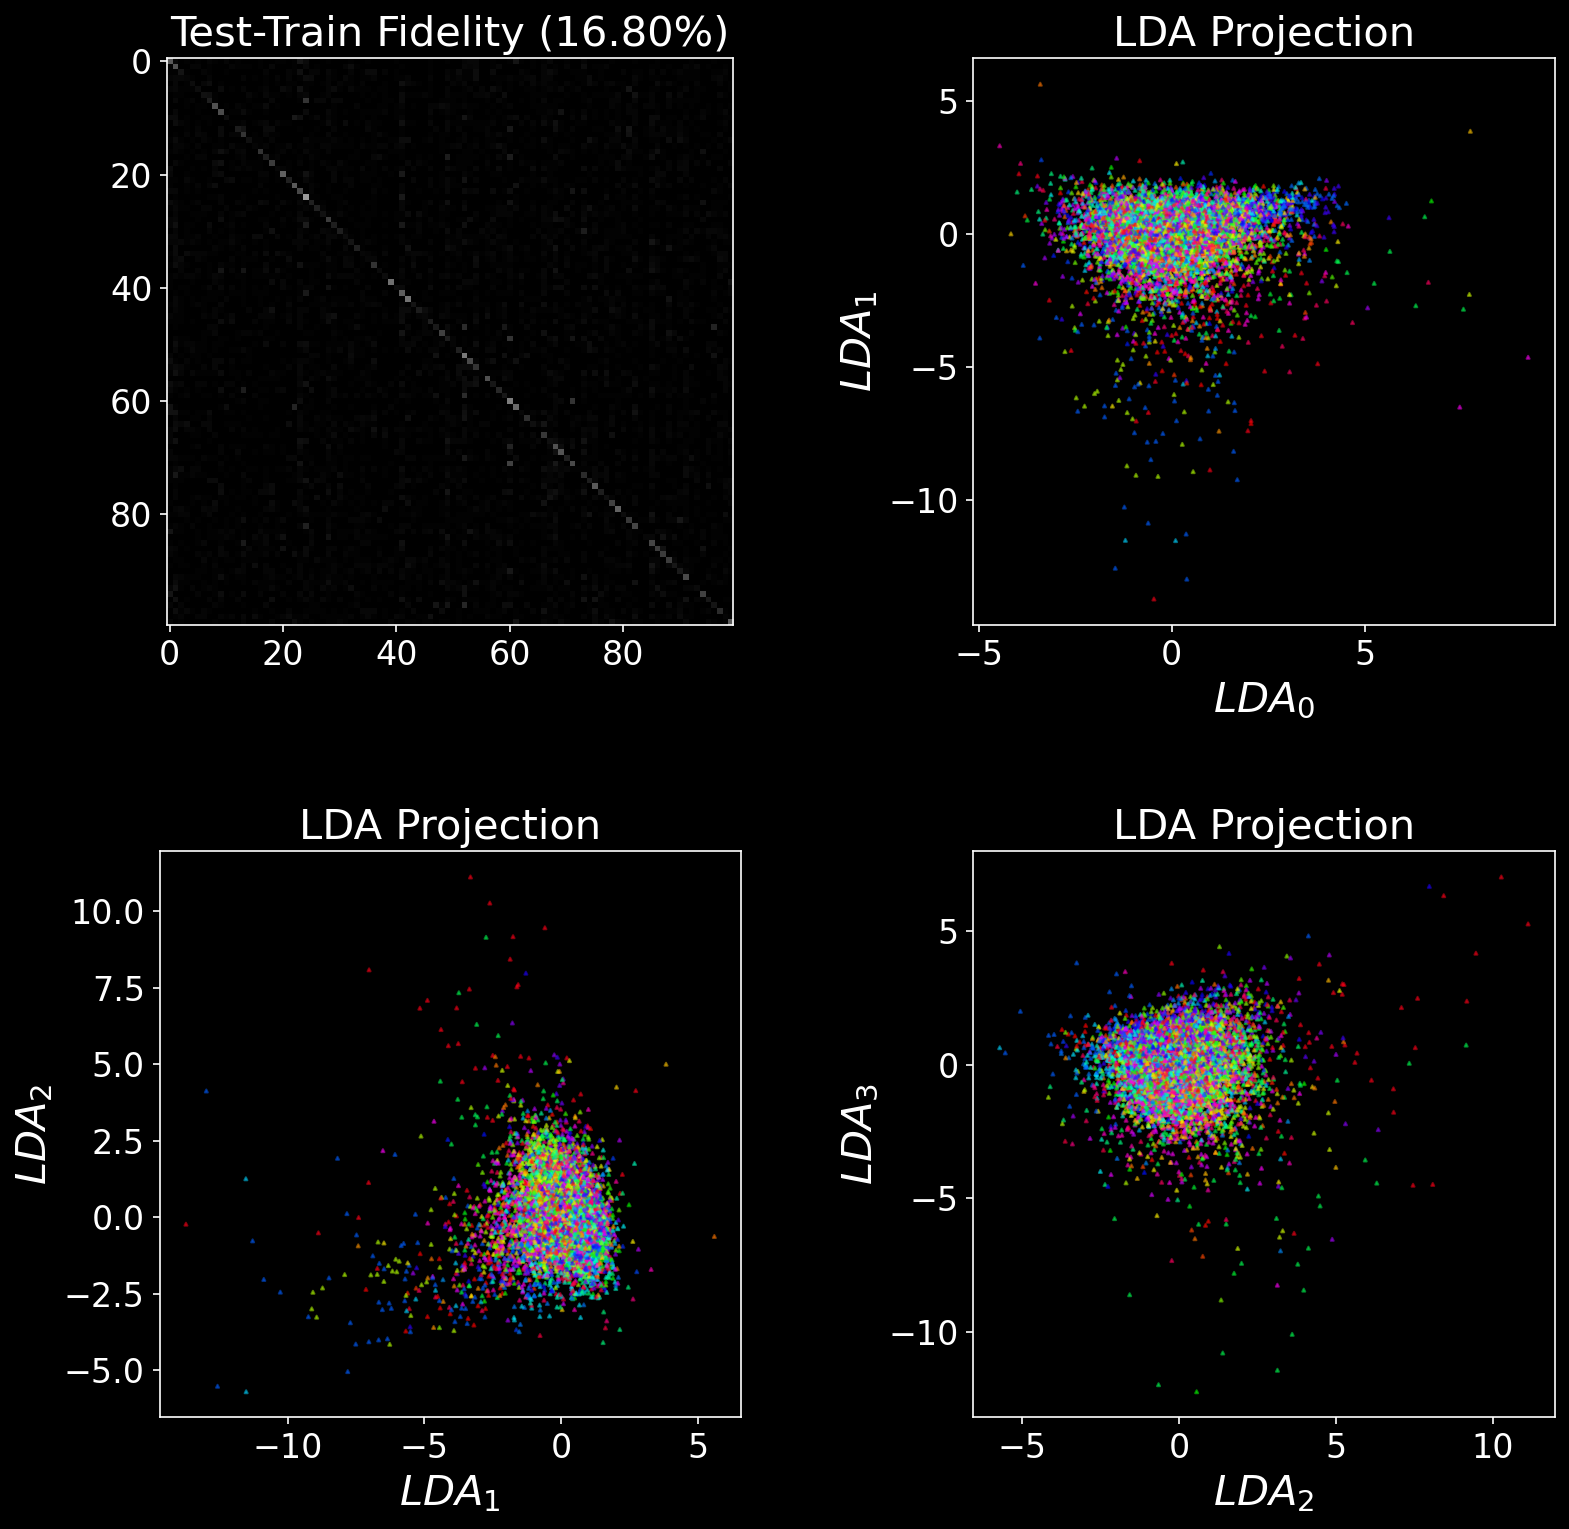

In [39]:
N = 100
labels = [i for i in range(100)]
out = LDA_AKS_testman(DHC_iso_vec(cifar100_train,5,8),
                      np.array(train_ds.targets),
                      DHC_iso_vec(cifar100_test,5,8),
                      np.array(test_ds.targets),N-1,labels)

Accuracy0.2211


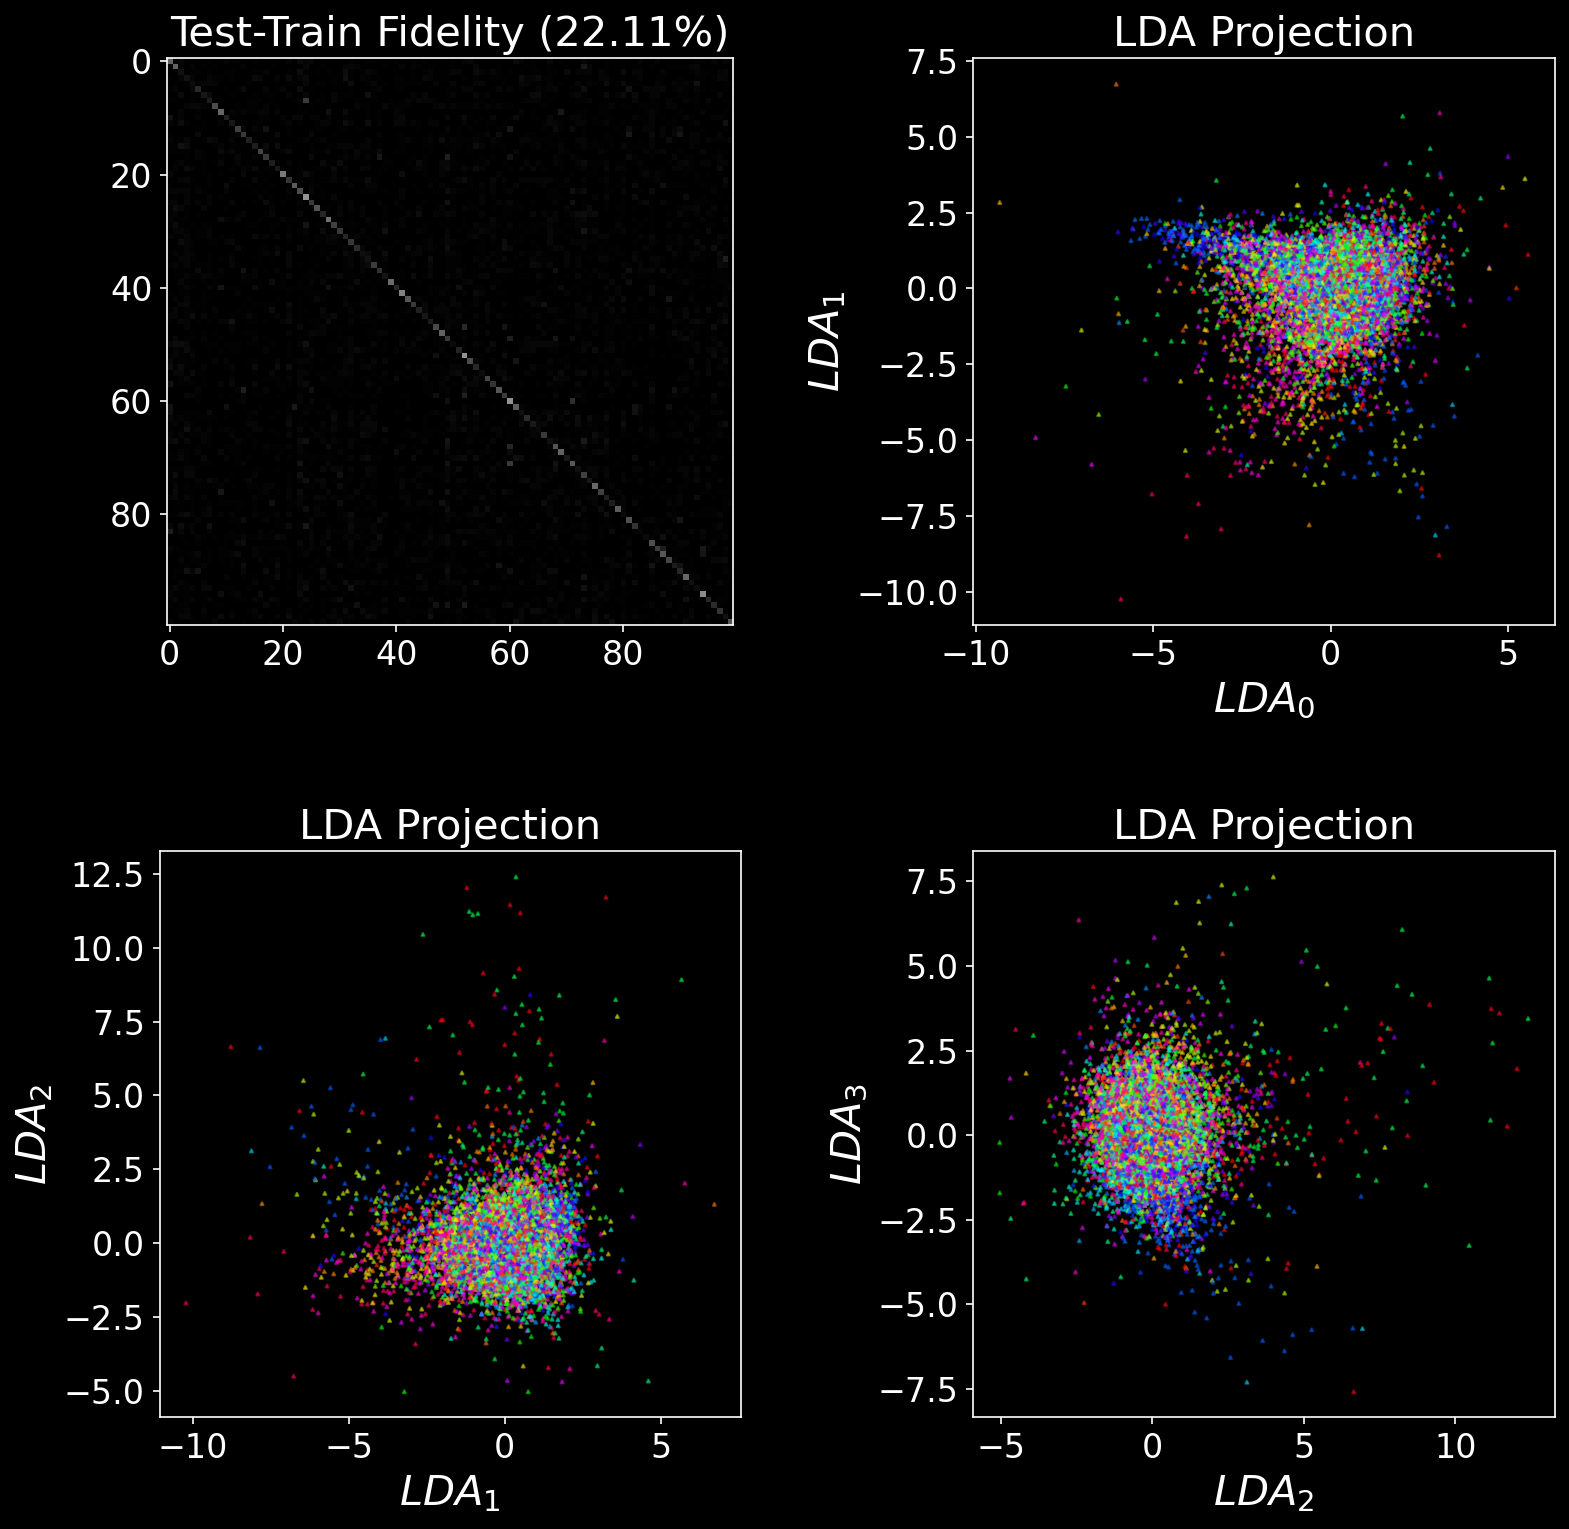

In [40]:
N = 100
labels = [i for i in range(100)]
out = LDA_AKS_testman(cifar100_train,
                      np.array(train_ds.targets),
                      cifar100_test,
                      np.array(test_ds.targets),N-1,classes)

In [51]:
def LDA_AKS_testman(X_train,y_train,X_test,y_test,n_components,label_list):
    lda = LDA(n_components=n_components)
    X_train = lda.fit_transform(X_train, y_train)
    y_pred = lda.predict(X_test)
    X_test = lda.transform(X_test)
    cm = confusion_matrix(y_test, y_pred)
    prec = precision_score(y_test, y_pred,average='micro')
    print('Accuracy' + str(prec))
    cmap_normal = (cm.T/cm.sum(axis=1)).T
    
    ## Good plots
    vmin=y_train.min()
    vmax=y_train.max()
    marker_size = 10

    from matplotlib import cm as cmplt
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    rgba_colors = [cmplt.hsv(norm(indx)) for indx, i in enumerate(label_list)]
    color_order = ["black", "white"]
    color_map = "gray"
    colormap='hsv'
    
    fig = plt.figure(figsize=(12,12),dpi=150)

    ax = fig.add_subplot(2,2,1)    
    ax.imshow(cmap_normal,
          interpolation='nearest',
          cmap=color_map,
          aspect='equal',
          vmin=0,vmax=1)

    ax.set_xticks(np.arange(cm.shape[0]))
    ax.set_yticks(np.arange(cm.shape[1]))
    
    for ytick, color in zip(ax.get_yticklabels(), rgba_colors):
        ytick.set_color(color)

    ax.set_xticklabels(label_list)
    ax.set_yticklabels(label_list)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",va='center',
             rotation_mode="anchor")
    plt.title('Test-Train Fidelity ({:.2f}%)'.format(100*prec))

    # Loop over data dimensions and create text annotations.
    #textcolors=color_order
    #threshold = 0.5
    #for i in range(cm.shape[0]):
    #    for j in range(cm.shape[1]):
    #        if cm[i, j] != 0:
    #            text = ax.text(j, i, cm[i, j],
    #                           ha="center", va="center", 
    #                           color=textcolors[int(cmap_normal[i, j] < threshold)])
    if n_components == 1:
        ax = fig.add_subplot(2,2,2)
        #ax.scatter(X_train, y_train, s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
        #ax.scatter(X_test, y_test, s=2, marker='^', zorder=10,c=y_test, cmap = 'bwr',alpha=0.5)
        sns.distplot(X_test[y_test==0],ax=ax)
        sns.distplot(X_test[y_test==1],ax=ax)
        plt.xlabel('$LDA_{}$'.format(0))
        plt.ylabel('Probability Density')
        plt.title('LDA Projection')
        
    if n_components == 2:
        ax = fig.add_subplot(2,2,2)
        #ax.scatter(X_train[:,0], X_train[:,1], s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
        ax.scatter(X_test[:,0], X_test[:,1], s=2, marker='^', zorder=10,c=y_test, cmap = colormap, vmin=vmin, vmax=vmax,alpha=0.5)
        plt.xlabel('$LDA_{}$'.format(i-2))
        plt.ylabel('$LDA_{}$'.format(i-1))
        plt.title('LDA Projection')
    elif n_components > 2:
        for i in range(2,5):
            ax = fig.add_subplot(2,2,i)
            #ax.scatter(X_train[:,i-2], X_train[:,i-1], s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
            ax.scatter(X_test[:,i-2], X_test[:,i-1], s=2, marker='^', zorder=10,c=y_test, cmap = colormap, vmin=vmin, vmax=vmax,alpha=0.5)
            plt.xlabel('$LDA_{}$'.format(i-2))
            plt.ylabel('$LDA_{}$'.format(i-1))
            plt.title('LDA Projection')

    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()
    
    return (lda,cm,X_train,X_test,y_train,y_test,y_pred)

Accuracy0.1627


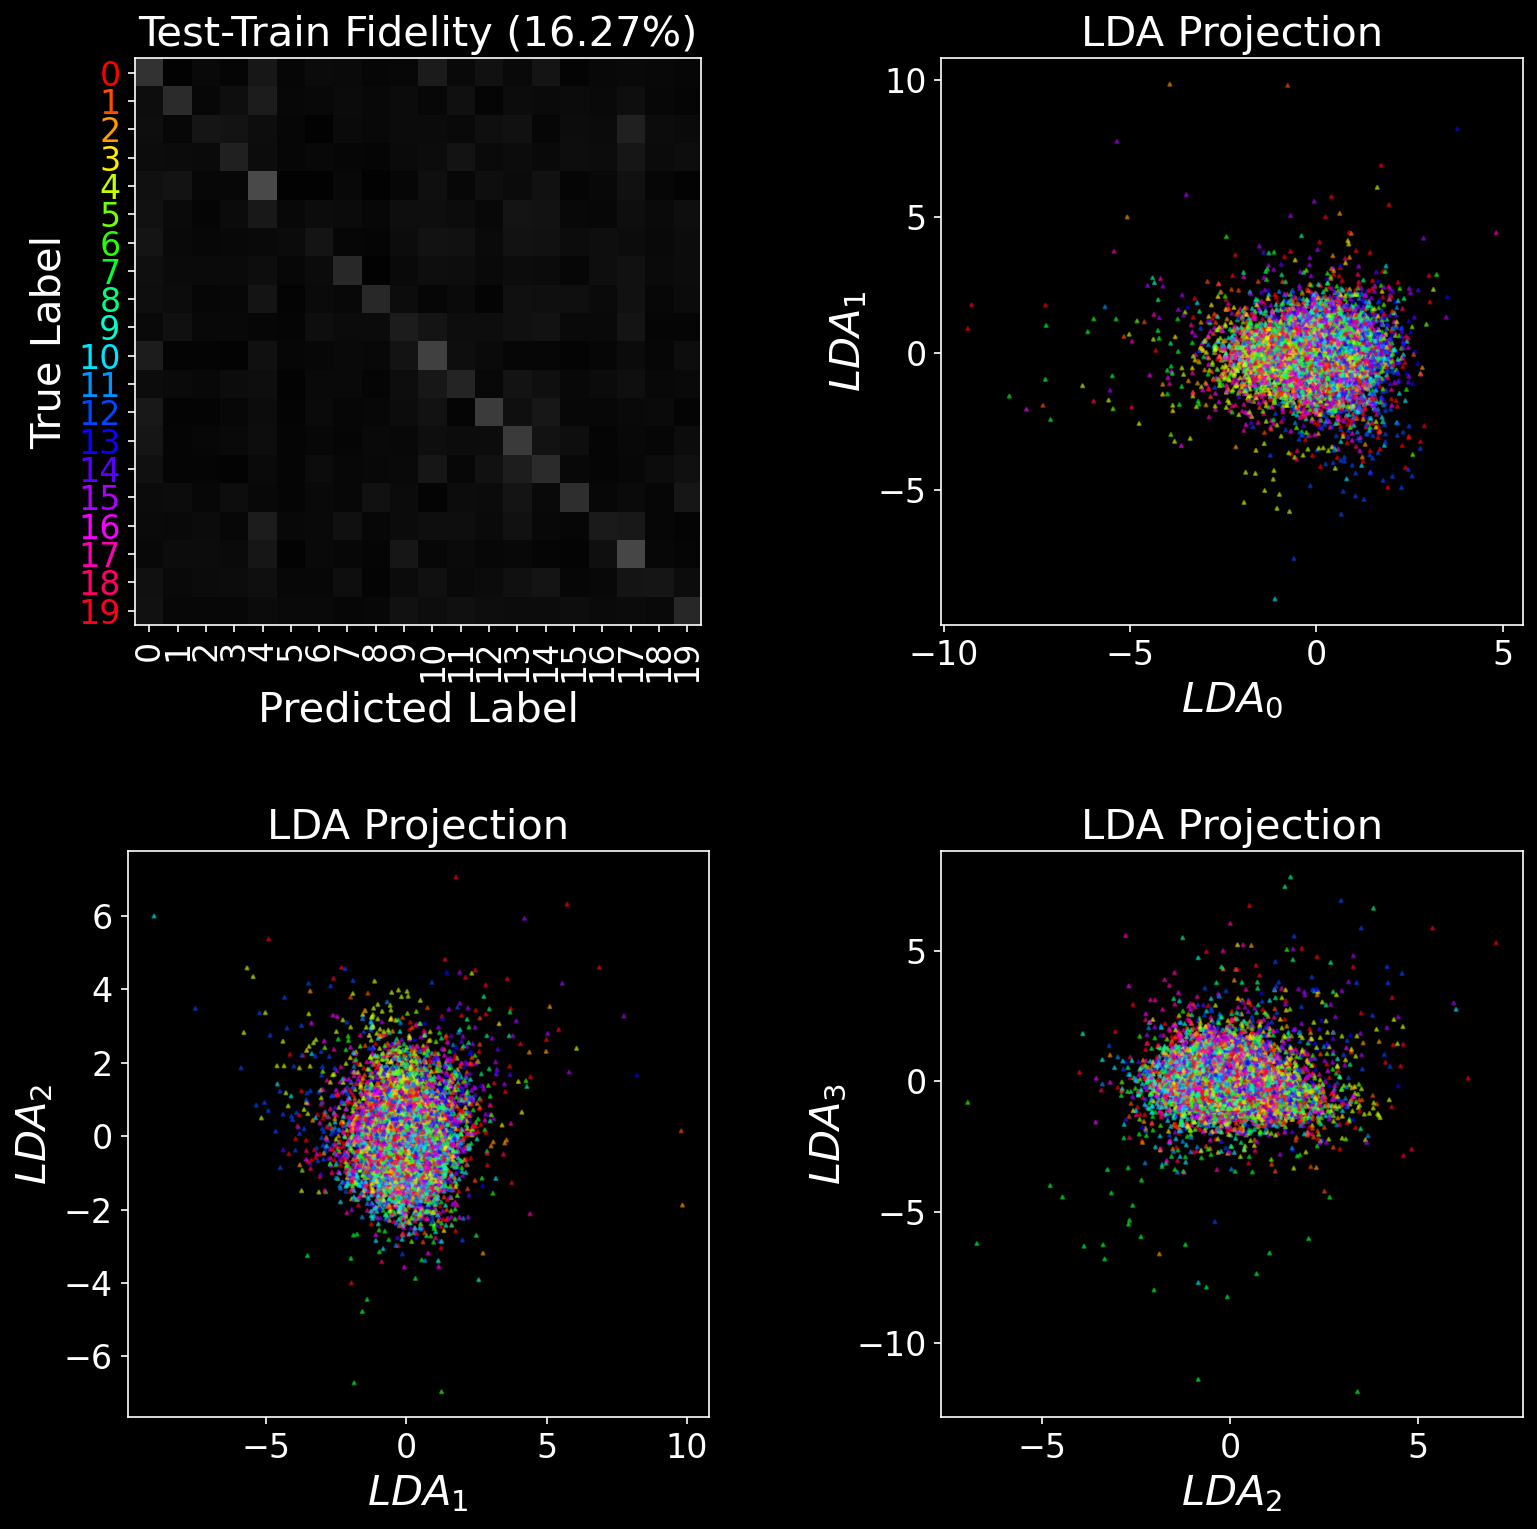

In [52]:
N = 20
labels = [i for i in range(20)]
out = LDA_AKS_testman(DHC_iso_vec(cifar100_train,5,8),
                      np.floor(np.array(train_ds.targets)/5.0),
                      DHC_iso_vec(cifar100_test,5,8),
                      np.floor(np.array(test_ds.targets)/5.0),N-1,labels)

Accuracy0.2036


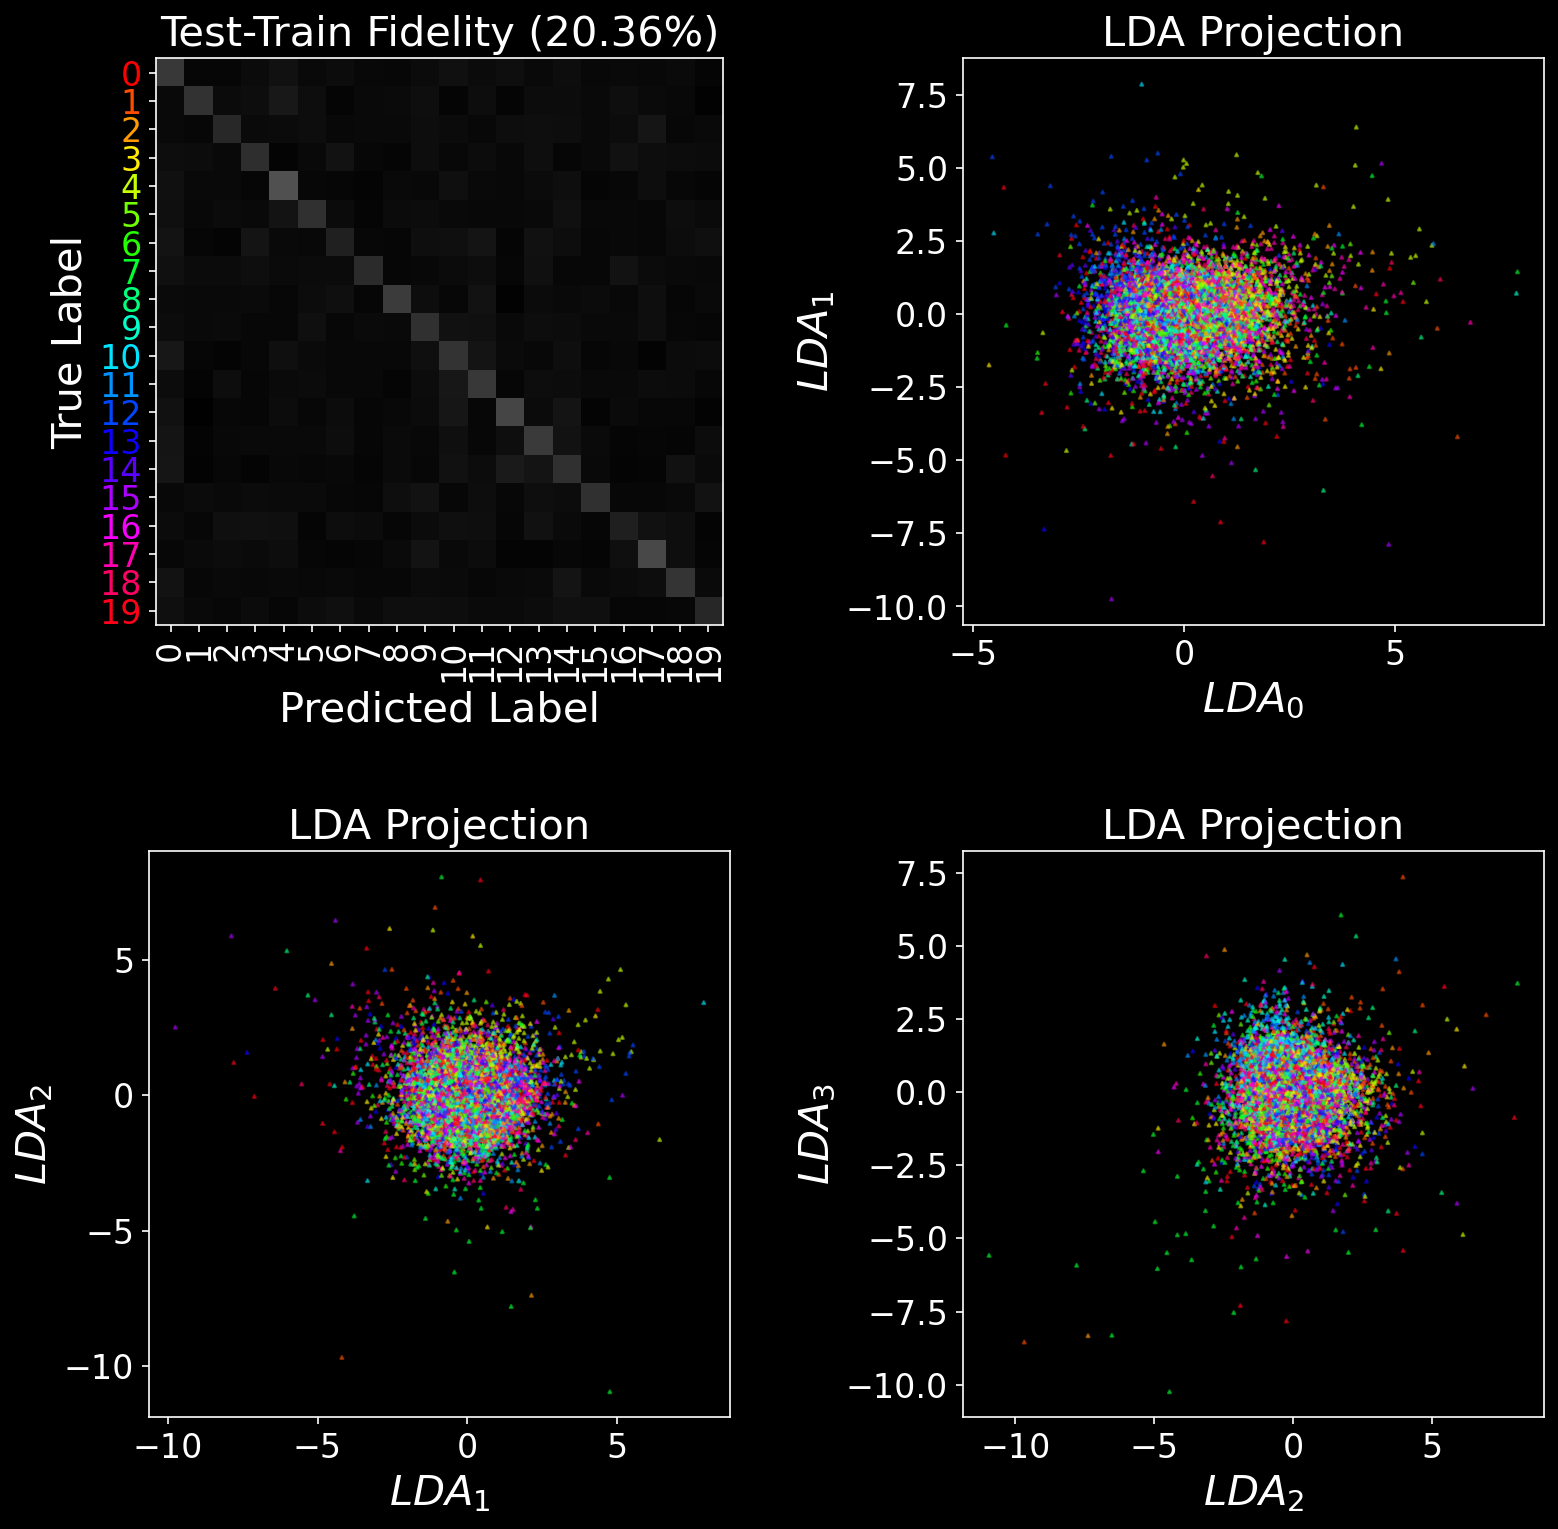

In [53]:
N = 20
labels = [i for i in range(20)]
out = LDA_AKS_testman(cifar100_train,
                      np.floor(np.array(train_ds.targets)/5.0),
                      cifar100_test,
                      np.floor(np.array(test_ds.targets)/5.0),N-1,labels)

Questions about the DPSS window

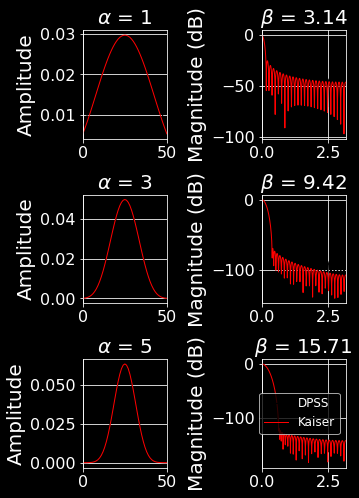

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows, freqz
M = 51
fig, axes = plt.subplots(3, 2, figsize=(5, 7))
for ai, alpha in enumerate((1, 3, 5)):
    win_dpss = windows.dpss(M, alpha)
    beta = alpha*np.pi
    win_kaiser = windows.kaiser(M, beta)
    for win, c in ((win_dpss, 'k'), (win_kaiser, 'r')):
        win /= win.sum()
        axes[ai, 0].plot(win, color=c, lw=1.)
        axes[ai, 0].set(xlim=[0, M-1], title=r'$\alpha$ = %s' % alpha,
                        ylabel='Amplitude')
        w, h = freqz(win)
        axes[ai, 1].plot(w, 20 * np.log10(np.abs(h)), color=c, lw=1.)
        axes[ai, 1].set(xlim=[0, np.pi],
                        title=r'$\beta$ = %0.2f' % beta,
                        ylabel='Magnitude (dB)')
for ax in axes.ravel():
    ax.grid(True)
axes[2, 1].legend(['DPSS', 'Kaiser'])
fig.tight_layout()
plt.show()

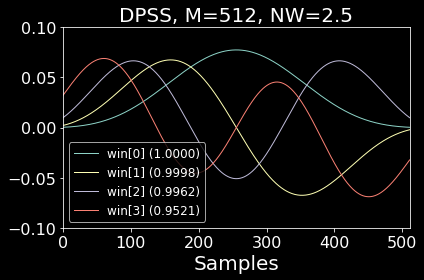

In [87]:
M = 512
NW = 2.5
win, eigvals = windows.dpss(M, NW, 4, return_ratios=True)
fig, ax = plt.subplots(1)
ax.plot(win.T, linewidth=1.)
ax.set(xlim=[0, M-1], ylim=[-0.1, 0.1], xlabel='Samples',
       title='DPSS, M=%d, NW=%0.1f' % (M, NW))
ax.legend(['win[%d] (%0.4f)' % (ii, ratio)
           for ii, ratio in enumerate(eigvals)])
fig.tight_layout()

[(0.0, 511.0),
 Text(0.5, 0, 'Samples'),
 Text(0.5, 1.0, 'DPSS, M=512, NW=255.0')]

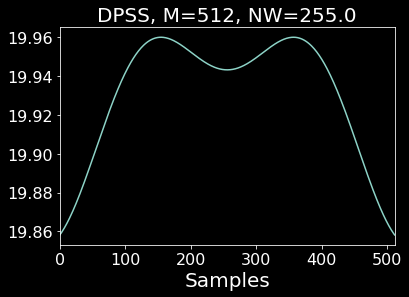

In [101]:
M = 512
NW = int(M/2)-1
win, eigvals = windows.dpss(M, NW, Kmax=2*NW-1, return_ratios=True,norm='approximate')
fig, ax = plt.subplots(1)
ax.plot(np.sum(np.square(win),axis=0))
ax.set(xlim=[0, M-1], xlabel='Samples',
       title='DPSS, M=%d, NW=%0.1f' % (M, NW))

[(0.0, 511.0),
 Text(0.5, 0, 'Samples'),
 Text(0.5, 1.0, 'DPSS, M=512, NW=100.0')]

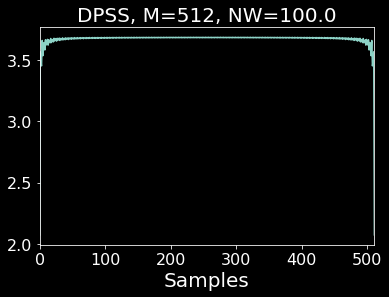

In [102]:
M = 512
NW = 100
win, eigvals = windows.dpss(M, NW, Kmax=2*NW-1, return_ratios=True,norm='approximate')
fig, ax = plt.subplots(1)
ax.plot(np.sum(np.square(win),axis=0))
ax.set(xlim=[0, M-1], xlabel='Samples',
       title='DPSS, M=%d, NW=%0.1f' % (M, NW))

In [106]:
temp = np.zeros((3, 2, 4))

for i in range(3):
    for j in range(2):
        for k in range(4):
            temp[i,j,k] = (i+1)*(j+1)*(k+1)

In [107]:
temp.flatten()

array([ 1.,  2.,  3.,  4.,  2.,  4.,  6.,  8.,  2.,  4.,  6.,  8.,  4.,
        8., 12., 16.,  3.,  6.,  9., 12.,  6., 12., 18., 24.])

This means all my coordinate manipulations were wrong so far... need to rethink all plots. Should all revise upwards in terms of invariance.

Overly dramatic. The indexing of the filters was right. It was just the ordering of the j1 and j2 that was flipped. This is the what np.transpose with permutations is for.

In [110]:
temp = hd5_open('../scratch_AKS/order_test.h5','main/data')

In [111]:
temp

array([ 1,  2,  3,  2,  4,  6,  2,  4,  6,  4,  8, 12,  3,  6,  9,  6, 12,
       18,  4,  8, 12,  8, 16, 24])

In [114]:
temp2 = np.transpose(temp.reshape(4,2,3), (2,1,0))

In [117]:
temp2[:,:,2]

array([[ 3,  6],
       [ 6, 12],
       [ 9, 18]])

In [ ]:
def DHC_iso_vec(wst,J,L):
    (nk, Nd) = np.shape(wst)
    S0 = wst[:,0:2]
    S1 = wst[:,2:J*L+2]
    S2 = np.transpose(np.reshape(wst[:,J*L+3:],(nk,(J*L+1),(J*L+1))),(0,2,1))
    
    S1iso = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            S1iso[:,j1] += S1[:,l1*J+j1]
    
    S2iso = np.zeros((nk,J,J,L))
    for j1 in range(J):
        for j2 in range(J):
            for l1 in range(L):
                for l2 in range(L):
                    deltaL = np.mod(l1-l2,L)
                    S2iso[:,j1,j2,deltaL] += S2[:,l1*J+j1,l2*J+j2]
                    
    Sphi1 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi1[:,j1] += S2[:,l1*J+j1,L*J]
            
    Sphi2 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi2[:,j1] += S2[:,L*J,l1*J+j1]
            
    return np.hstack((S0,S1iso,wst[:,J*L+2].reshape(nk,1),S2iso.reshape(nk,J*J*L),Sphi1,Sphi2,S2[:,L*J,L*J].reshape(nk,1)))